# Field-Aware Factorization Machine model
This notebook trains a Field-Aware Factorization Machine (libffm) for the kaggle competition: https://www.kaggle.com/c/porto-seguro-safe-driver-prediction.

Thanks to Scirpus for the data preparation script: https://www.kaggle.com/scirpus/libffm-generator-lb-280/notebook

In [13]:
import math
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
def gini(actual, pred, cmpcol = 0, sortcol = 1):
    assert( len(actual) == len(pred) )
    all = np.asarray(np.c_[ actual, pred, np.arange(len(actual)) ], dtype=np.float)
    all = all[ np.lexsort((all[:,2], -1*all[:,1])) ]
    totalLosses = all[:,0].sum()
    giniSum = all[:,0].cumsum().sum() / totalLosses
 
    giniSum -= (len(actual) + 1) / 2.
    return giniSum / len(actual)
 
def gini_normalized(a, p):
    return gini(a, p) / gini(a, a)

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
test.insert(1,'target',0)
print(train.shape)
print(test.shape)

(595212, 59)
(892816, 59)


In [7]:
kmeans = KMeans(n_clusters=8, init='k-means++', n_init=10, max_iter=300, tol=0.0001, precompute_distances='auto', 
                verbose=0, random_state=42, copy_x=True, n_jobs=1, algorithm='auto')
kmeans.fit(train.drop(['target', 'id'], axis=1))

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

In [8]:
train['cluster'] = kmeans.predict(train.drop(['target', 'id'], axis=1))
test['cluster'] = kmeans.predict(test.drop(['target', 'id'], axis=1))

In [9]:
train[['cluster', 'target']].groupby('cluster').agg(['mean', 'count'])

target        
             mean   count
cluster                  
0        0.039626  145032
1        0.038470   60176
2        0.037213   61269
3        0.035639  100647
4        0.035717   73718
5        0.030800   58961
6        0.039118   38473
7        0.031808   56936

In [10]:
unwanted = train.columns[train.columns.str.startswith('ps_calc_')]
train.drop(unwanted,inplace=True,axis=1)
test.drop(unwanted,inplace=True,axis=1)

In [11]:
def decode_ps_ind(x):
    if x.ps_ind_06_bin == 1:
        return 0
    elif x.ps_ind_07_bin == 1:
        return 1
    elif x.ps_ind_08_bin == 1:
        return 2
    elif x.ps_ind_09_bin == 1:
        return 3
    else:
        return -1

In [12]:
def add_features(df):
    best_features = ['ps_ind_03', 'ps_car_13', 'ps_reg_03', 'ps_ind_15']#, 'ps_car_12']#, 'ps_reg_02']
    for i in range(len(best_features)):
        for j in range(i+1, len(best_features)):
            df[str(best_features[i]+'_times_'+best_features[j])] = df[best_features[i]] * df[best_features[j]]
    
    dcol = [c for c in df.columns if c not in ['id','target']]
    df['negative_one_vals'] = np.sum((df[dcol]==-1).values, axis=1)
    
    return df

train = add_features(train)
test = add_features(test)

In [55]:
x = pd.concat([train,test])
x = x.reset_index(drop=True)

In [56]:
features = x.columns[2:]
categories = []
for c in features:
    trainno = len(x.loc[:train.shape[0],c].unique())
    testno = len(x.loc[train.shape[0]:,c].unique())
    print(c,trainno,testno)

ps_ind_01 8 8
ps_ind_02_cat 5 5
ps_ind_03 12 12
ps_ind_04_cat 3 3
ps_ind_05_cat 8 8
ps_ind_06_bin 2 2
ps_ind_07_bin 2 2
ps_ind_08_bin 2 2
ps_ind_09_bin 2 2
ps_ind_10_bin 2 2
ps_ind_11_bin 2 2
ps_ind_12_bin 2 2
ps_ind_13_bin 2 2
ps_ind_14 5 5
ps_ind_15 14 14
ps_ind_16_bin 2 2
ps_ind_17_bin 2 2
ps_ind_18_bin 2 2
ps_reg_01 10 10
ps_reg_02 19 19
ps_reg_03 5013 5046
ps_car_01_cat 13 13
ps_car_02_cat 3 3
ps_car_03_cat 3 3
ps_car_04_cat 10 10
ps_car_05_cat 3 3
ps_car_06_cat 18 18
ps_car_07_cat 3 3
ps_car_08_cat 2 2
ps_car_09_cat 6 6
ps_car_10_cat 3 3
ps_car_11_cat 104 104
ps_car_11 5 5
ps_car_12 184 201
ps_car_13 70482 83769
ps_car_14 850 885
ps_car_15 15 15
cluster 8 8
ps_ind_03_times_ps_car_13 230510 286555
ps_ind_03_times_ps_reg_03 42023 44728
ps_ind_03_times_ps_ind_15 70 70
ps_car_13_times_ps_reg_03 512976 756376
ps_car_13_times_ps_ind_15 250332 314208
ps_reg_03_times_ps_ind_15 48502 51714
negative_one_vals 9 9


In [57]:
x.loc[:,'ps_reg_03'] = pd.cut(x['ps_reg_03'], 35, labels=False)
x.loc[:,'ps_car_12'] = pd.cut(x['ps_car_12'], 35, labels=False)
x.loc[:,'ps_car_13'] = pd.cut(x['ps_car_13'], 35, labels=False)
x.loc[:,'ps_car_14'] =  pd.cut(x['ps_car_14'], 35, labels=False)
x.loc[:,'ps_car_15'] =  pd.cut(x['ps_car_15'], 35, labels=False)

x.loc[:,'ps_ind_03_times_ps_car_13'] =  pd.cut(x['ps_ind_03_times_ps_car_13'], 30, labels=False) 
x.loc[:,'ps_ind_03_times_ps_reg_03'] =  pd.cut(x['ps_ind_03_times_ps_reg_03'], 20, labels=False) 
x.loc[:,'ps_ind_03_times_ps_ind_15'] =  pd.cut(x['ps_ind_03_times_ps_ind_15'], 10, labels=False)
x.loc[:,'ps_car_13_times_ps_reg_03'] =  pd.cut(x['ps_car_13_times_ps_reg_03'], 50, labels=False) 
x.loc[:,'ps_car_13_times_ps_ind_15'] =  pd.cut(x['ps_car_13_times_ps_ind_15'], 30, labels=False) 
x.loc[:,'ps_reg_03_times_ps_ind_15'] =  pd.cut(x['ps_reg_03_times_ps_ind_15'], 20, labels=False) 

In [58]:
test = x[len(train):].copy()
train = x[:len(train)].copy()

In [60]:
train.drop('id',inplace=True,axis=1)
test.drop('id',inplace=True,axis=1)

In [61]:
numerics = []
categories = train.columns[1:]

currentcode = len(numerics)
catdict = {}
catcodes = {}

for x in numerics:
    catdict[x] = 0
for x in categories:
    catdict[x] = 1

In [62]:
noofcolumns = len(features)

with open("ffm/alltestffm.txt", "w") as text_file:
    for n, r in enumerate(range(test.shape[0])):
        if((n%100000)==0):
            print('Row',n)
        datastring = ""
        datarow = test.iloc[r].to_dict()
        datastring += str(int(datarow['target']))


        for i, x in enumerate(catdict.keys()):
            if(catdict[x]==0):
                datastring = datastring + " "+str(i)+":"+ str(i)+":"+ str(datarow[x])
            else:
                if(x not in catcodes):
                    catcodes[x] = {}
                    currentcode +=1
                    catcodes[x][datarow[x]] = currentcode
                elif(datarow[x] not in catcodes[x]):
                    currentcode +=1
                    catcodes[x][datarow[x]] = currentcode

                code = catcodes[x][datarow[x]]
                datastring = datastring + " "+str(i)+":"+ str(int(code))+":1"
        datastring += '\n'
        text_file.write(datastring)

Row 0
Row 100000
Row 200000
Row 300000
Row 400000
Row 500000
Row 600000
Row 700000
Row 800000


In [63]:
from sklearn.model_selection import StratifiedKFold
cv_splits = 10 #5 for first 10

noofcolumns = len(features)

for run in range(10, 15):
    kf = StratifiedKFold(n_splits = cv_splits, shuffle = True, random_state = 700+run)

    for fold, (train_index, valid_index) in enumerate(kf.split(train, train['target'].values.ravel())):
        currentcode2 = currentcode

        print('Run {} Fold {}'.format(run, fold))
        X_train = train.iloc[train_index, :]#.loc[:, features]
        #y_train = train.iloc[train_index, :]['target'].values.ravel()
        X_valid = train.iloc[valid_index, :]#.loc[:, features]
        #y_valid = train.iloc[valid_index, :]['target'].values.ravel()

        with open("ffm/train_run{}_fold{}.txt".format(run, fold), "w") as text_file:
            for n, r in enumerate(range(len(X_train))):
                if((n%100000)==0):
                    print('Row',n)
                datastring = ""
                datarow = X_train.iloc[r].to_dict()
                datastring += str(int(datarow['target']))


                for i, x in enumerate(catdict.keys()):
                    if(catdict[x]==0):
                        datastring = datastring + " "+str(i)+":"+ str(i)+":"+ str(datarow[x])
                    else:
                        if(x not in catcodes):
                            catcodes[x] = {}
                            currentcode2 +=1
                            catcodes[x][datarow[x]] = currentcode2
                        elif(datarow[x] not in catcodes[x]):
                            currentcode2 +=1
                            catcodes[x][datarow[x]] = currentcode2

                        code = catcodes[x][datarow[x]]
                        datastring = datastring + " "+str(i)+":"+ str(int(code))+":1"
                datastring += '\n'
                text_file.write(datastring)    

        with open("ffm/valid_run{}_fold{}.txt".format(run, fold), "w") as text_file:
            for n, r in enumerate(range(len(X_valid))):
                if((n%100000)==0):
                    print('Row',n)
                datastring = ""
                datarow = X_valid.iloc[r].to_dict()
                datastring += str(int(datarow['target']))


                for i, x in enumerate(catdict.keys()):
                    if(catdict[x]==0):
                        datastring = datastring + " "+str(i)+":"+ str(i)+":"+ str(datarow[x])
                    else:
                        if(x not in catcodes):
                            catcodes[x] = {}
                            currentcode2 +=1
                            catcodes[x][datarow[x]] = currentcode2
                        elif(datarow[x] not in catcodes[x]):
                            currentcode2 +=1
                            catcodes[x][datarow[x]] = currentcode2

                        code = catcodes[x][datarow[x]]
                        datastring = datastring + " "+str(i)+":"+ str(int(code))+":1"
                datastring += '\n'
                text_file.write(datastring)
print('finished')

Run 10 Fold 0
Row 0
Row 100000
Row 200000
Row 300000
Row 400000
Row 500000
Row 0
Run 10 Fold 1
Row 0
Row 100000
Row 200000
Row 300000
Row 400000
Row 500000
Row 0
Run 10 Fold 2
Row 0
Row 100000
Row 200000
Row 300000
Row 400000
Row 500000
Row 0
Run 10 Fold 3
Row 0
Row 100000
Row 200000
Row 300000
Row 400000
Row 500000
Row 0
Run 10 Fold 4
Row 0
Row 100000
Row 200000
Row 300000
Row 400000
Row 500000
Row 0
Run 10 Fold 5
Row 0
Row 100000
Row 200000
Row 300000
Row 400000
Row 500000
Row 0
Run 10 Fold 6
Row 0
Row 100000
Row 200000
Row 300000
Row 400000
Row 500000
Row 0
Run 10 Fold 7
Row 0
Row 100000
Row 200000
Row 300000
Row 400000
Row 500000
Row 0
Run 10 Fold 8
Row 0
Row 100000
Row 200000
Row 300000
Row 400000
Row 500000
Row 0
Run 10 Fold 9
Row 0
Row 100000
Row 200000
Row 300000
Row 400000
Row 500000
Row 0
Run 11 Fold 0
Row 0
Row 100000
Row 200000
Row 300000
Row 400000
Row 500000
Row 0
Run 11 Fold 1
Row 0
Row 100000
Row 200000
Row 300000
Row 400000
Row 500000
Row 0
Run 11 Fold 2
Row 0
Row 1000

In [65]:
import os
from sklearn.model_selection import StratifiedKFold

#libffm_path = '../../../libffm/'
libffm_path = '../../../libffm_patience/libffm_gini/'

reg_lambda = 2e-6
k = 7
t = 500
eta = 0.02
n_jobs = 1
auto_stop = True
patience = 5
cv_splits = 10 #5 for first 10

if False: # only for first use 
    df_preds_ffm = pd.DataFrame(pd.read_csv('test.csv')['id'])
    df_preds_ffm.to_csv('Predictions/Base/ffm/test.csv', index = False)
    df_preds_train_ffm = pd.DataFrame(pd.read_csv('train.csv')['id'])
    df_preds_train_ffm.to_csv('Predictions/Base/ffm/train.csv', index = False)

for run in range(11, 15):
    kf = StratifiedKFold(n_splits = cv_splits, shuffle = True, random_state = 700+run)
    preds_ffm = np.zeros(len(test))
    preds_tr_ffm = np.zeros(len(train))

    for fold, (train_index, valid_index) in enumerate(kf.split(train, train['target'].values.ravel())):
        os.system(libffm_path + 'ffm-train -p ffm/valid_run{0}_fold{1}.txt {2} -l {3} -k {4} -t {5} -r {6} -s {7} -b {8} ffm/train_run{0}_fold{1}.txt'.format(run, fold, '--auto-stop' if auto_stop else '', reg_lambda, k, t, eta, n_jobs, patience))
        os.system('mv train_run{0}_fold{1}.txt.bin ffm/train_run{0}_fold{1}.txt.bin'.format(run, fold))
        os.system('mv train_run{0}_fold{1}.txt.model ffm/train_run{0}_fold{1}.txt.model'.format(run, fold))
        os.system('mv valid_run{0}_fold{1}.txt.bin ffm/valid_run{0}_fold{1}.txt.bin'.format(run, fold))
        os.system(libffm_path + 'ffm-predict ffm/valid_run{0}_fold{1}.txt ffm/train_run{0}_fold{1}.txt.model ffm/predictions_valid_run{0}_fold{1}.txt'.format(run, fold))
        os.system(libffm_path + 'ffm-predict ffm/alltestffm.txt ffm/train_run{0}_fold{1}.txt.model ffm/predictions_test_run{0}_fold{1}.txt'.format(run, fold))

        preds = pd.read_csv('ffm/predictions_valid_run{0}_fold{1}.txt'.format(run, fold), header = None)
        X_train = train.iloc[train_index, :]
        X_valid = train.iloc[valid_index, :]
        y_valid = train.iloc[valid_index, :]['target'].values.ravel()

        preds_tr_ffm[valid_index] += preds.values.ravel()
        print('Score: {:0.4f}'.format(gini_normalized(y_valid, preds)))

    print('CV Score: {:0.4f}'.format(gini_normalized(train['target'].values.ravel(), preds_tr_ffm)))
    
    preds_ffm = pd.read_csv('ffm/predictions_test_run{0}_fold0.txt'.format(run), header = None)
    for i in range(1, cv_splits):
        preds_ffm[str(i)] = pd.read_csv('ffm/predictions_test_run{0}_fold{1}.txt'.format(run, i), header = None).values
    preds_ffm = np.mean(preds_ffm, axis = 1)
    
    df_preds_ffm = pd.read_csv('Predictions/Base/ffm/test.csv')
    df_preds_ffm[str(run)] = preds_ffm
    df_preds_ffm.to_csv('Predictions/Base/ffm/test.csv', index = False)

    df_preds_train_ffm = pd.read_csv('Predictions/Base/ffm/train.csv')
    df_preds_train_ffm[str(run)] = preds_tr_ffm
    df_preds_train_ffm.to_csv('Predictions/Base/ffm/train.csv', index = False)

Score: 0.2693
CV Score: 0.0021
Score: 0.2982
Score: 0.2927
Score: 0.2918
Score: 0.2886
Score: 0.2766
Score: 0.2923
Score: 0.2737
Score: 0.2868
Score: 0.2752
Score: 0.2785
CV Score: 0.2854
Score: 0.2629
Score: 0.2550
Score: 0.2814
Score: 0.3088
Score: 0.2896
Score: 0.2860
Score: 0.2948
Score: 0.2841
Score: 0.2894
Score: 0.2968
CV Score: 0.2847
Score: 0.2876
Score: 0.2847
Score: 0.2826
Score: 0.2796
Score: 0.2852
Score: 0.2776
Score: 0.2928
Score: 0.2913
Score: 0.2822
Score: 0.2856
CV Score: 0.2847


In [5]:
df_train = pd.read_csv('train.csv')

def print_scores(df):
    for c in [col for col in df.columns if col not in ['id']]:
        print('Score: {:0.4f}'.format(gini_normalized(df_train['target'], df[c])))

df_preds_ffm = pd.read_csv('Predictions/Base/ffm/test.csv')
df_preds_train_ffm = pd.read_csv('Predictions/Base/ffm/train.csv')

preds_tr_ffm = np.mean(df_preds_train_ffm.drop('id', axis = 1).values, axis = 1)

print_scores(df_preds_train_ffm)
print('\nCombined')
print('Score: {:0.4f}'.format(gini_normalized(df_train['target'], preds_tr_ffm)))
del df_train

Score: 0.2845
Score: 0.2837
Score: 0.2832
Score: 0.2813
Score: 0.2845

Combined
Score: 0.2853


# Predict test sample

In [18]:
df_test = pd.read_csv('test.csv')
df_test.head()

,id,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,0,0,1,8,1,0,0,1,0,0,...,1,1,1,12,0,1,1,0,0,1
1,1,4,2,5,1,0,0,0,0,1,...,2,0,3,10,0,0,1,1,0,1
2,2,5,1,3,0,0,0,0,0,1,...,4,0,2,4,0,0,0,0,0,0
3,3,0,1,6,0,0,1,0,0,0,...,5,1,0,5,1,0,1,0,0,0
4,4,5,1,7,0,0,0,0,0,1,...,4,0,0,4,0,1,1,0,0,1


In [22]:
df_test = pd.read_csv('test.csv')
df_test['target'] = np.mean(df_preds_ffm.drop('id', axis = 1).values, axis = 1)
df_test[['id', 'target']].to_csv('submission_ffm.csv.gz', index = False, compression = 'gzip', float_format='%.6f')
del df_test

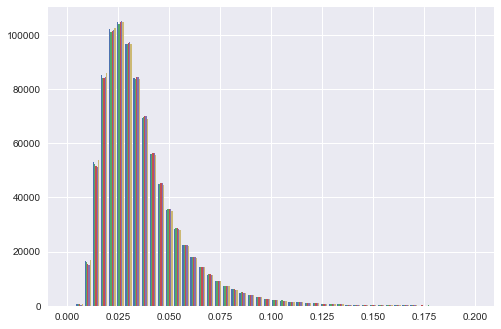

In [25]:
import matplotlib.pyplot as plt
import seaborn
plt.hist(df_preds_ffm.drop('id', axis = 1).values, bins = 50, range = (0, 0.2))
plt.show()